# Homework Project 3

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import eigsh
import hdbscan
import umap
from sklearn.preprocessing import StandardScaler

np.random.seed(1)

### We took intraday price values for an asset, spanning a total of 45000 minutes.  This time series was then split into half-hour intervals for a total of 1500 intervals.

### There are 1500 lines in this file, one for each half-hour interval.  Each line begins with the count of the corresponding half-hour.

In [28]:
# real data
df = pd.read_csv('./data/polluted_deltas_new.csv', header=None)
df = df.iloc[:, 2:]

# X is the original value array
X = df.values
n, p = X.shape
print(f'n: {n}; p: {p}')

# fake simulation
# n, p = 1500, 30
# X = np.random.normal(loc=0, scale=1, size=(n, p))
# t1, t2 = 10, 30
# X[t1:t2, :] = np.random.normal(loc=6, scale=1, size=(t2-t1, p))

n: 1709; p: 29


### The data was constructed as follows for each half hour interval $t$.  Suppose that $p(t, k)$ denotes the price of the asset in minute $k$ of half-hour $t$.  Here $k = 0,1,\ldots, 29$.  
### The data in position $k+1$ of line $t$ of the file equals $p(t,k) - p(t,0)$, i.e. the change in price between minute $k$ and minute $0$.

### EXCEPT that:
### The data was <font color = "red">polluted</font> in a <font color = "red">significant and correlated</font> manner during a certain interval $[t_1, t_2]$ of half-hours.
### Your task is to identify this interval $[t_1, t_2]$ as closely as possible, using <font color = "red">covariance analysis techniques</font>.
### Please note that we are not interested in small, random noise.  We are looking for a large change in the covariance structure. 

In [29]:
# desired dimensionality of the embedding FOR BOTH PCA AND UMAP
k = 2

### PCA COMPUTATIONS FIRST ###
# Y will be the k-dimensional embedding of X
Y = None
# cov is the covariance matrix of X
c = X - X.mean(axis=0)
cov = (c.T @ c) / (n-1)
# pulling out k largest eigenvalues and associated eigenvectors
vals, vecs = eigsh(cov, k=k, which='LA')
# sorting from largest to smallest
vals, vecs = vals[::-1], np.flip(vecs, axis=1)
# projecting old data using the eigenvectors
Y = X.dot(vecs)

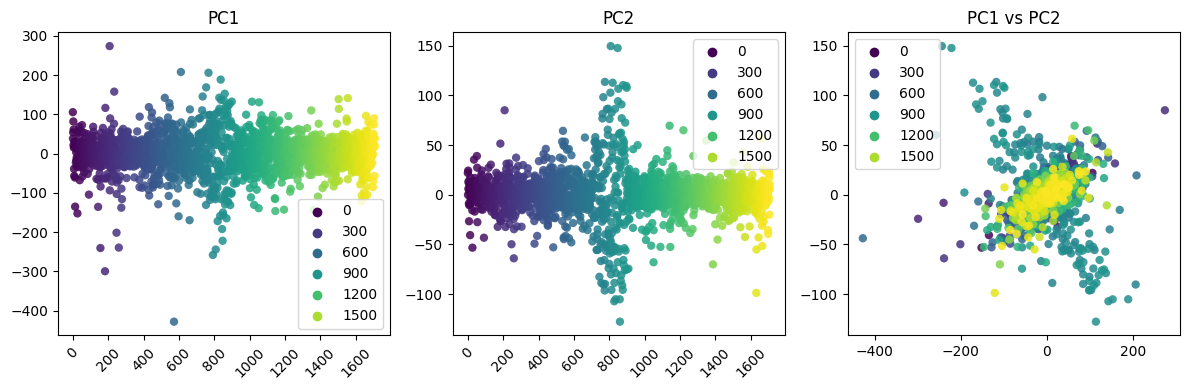

In [30]:
# plotting PCA components
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(x=range(n), y=Y[:, 0], hue=range(n), linewidth=0, alpha=0.85, palette='viridis', ax=ax[0])
ax[0].set_title('PC1')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)

sns.scatterplot(x=range(n), y=Y[:, 1], hue=range(n), linewidth=0, alpha=0.85, palette='viridis', ax=ax[1])
ax[1].set_title('PC2')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)

sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=range(n), linewidth=0, alpha=0.85, palette='viridis', ax=ax[2])
ax[2].set_title('PC1 vs PC2')

plt.tight_layout()
plt.show()

In [31]:
### UMAP COMPUTATIONS SECOND ###
# main umap hyperparameter influencing balance
# between local and global structure
umap_neighbors = 30
# minimum number of points to be considered a cluster
dbscan_min_cluster_size = 25
# euclidean distance becomes less meaningful in high dimensions
dbscan_metric = 'euclidean' if k <= 2 else 'canberra'
# Y will be the k-dimensional embedding of X
Y = None
# standardizing features to mean 0 and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# computing UMAP embedding
reducer = umap.UMAP(n_neighbors=umap_neighbors, n_components=k, metric='canberra', init='random', verbose=False)
Y = reducer.fit_transform(X_scaled)

# take cluster size minimum to be 1% of n=1500, for example
clust = hdbscan.HDBSCAN(min_cluster_size=dbscan_min_cluster_size, metric=dbscan_metric).fit(Y)
assgn, probs = clust.labels_, clust.probabilities_

Clusters present (-1 is noise): {0, 1, -1}


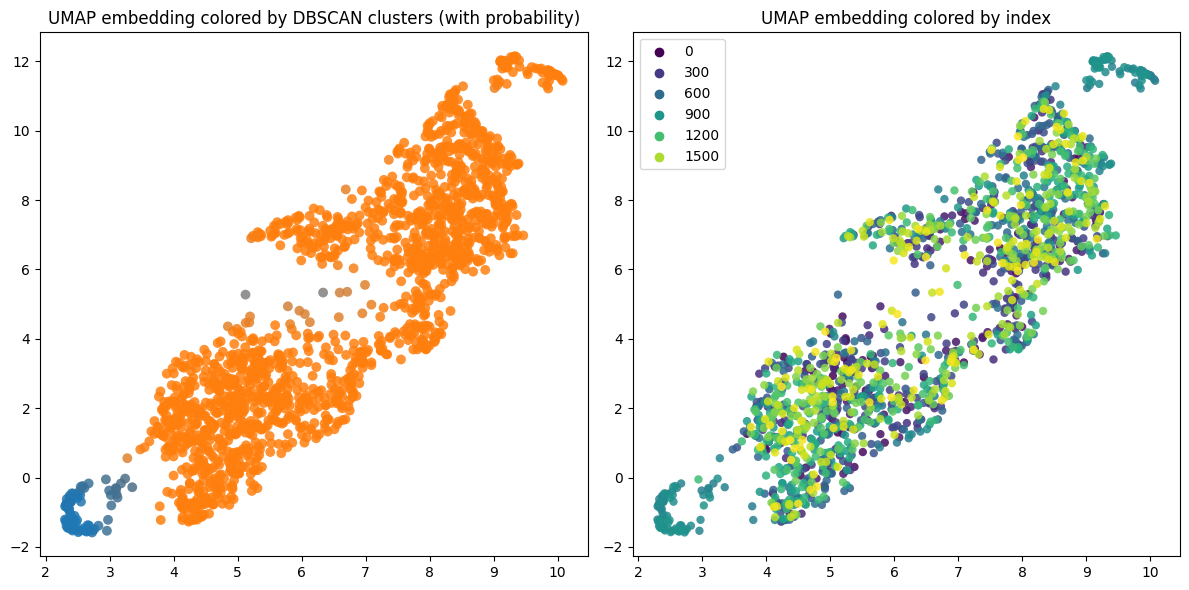

In [32]:
# plotting UMAP embedding
unq_assgn = set(assgn)
print('Clusters present (-1 is noise):', unq_assgn)

color_palette = sns.color_palette('tab10', len(unq_assgn) - (1 if -1 in unq_assgn else 0))
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in assgn]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, probs)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(x=Y[:, 0], y=Y[:, 1], c=cluster_member_colors, s=50, linewidth=0, alpha=0.85)
ax[0].set_title('UMAP embedding colored by DBSCAN clusters (with probability)')

sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=range(n), palette='viridis', linewidth=0, alpha=0.85, ax=ax[1])
ax[1].set_title('UMAP embedding colored by index')

plt.tight_layout()
plt.show()

In [36]:
### MAKING A GUESS AS TO RANGE OF POLLUTION ###
for c in unq_assgn:
    if c == -1: continue
    tmp = df.loc[assgn == c, :].index.tolist()
    tmp = sorted(tmp)
    diff = set(tmp).difference(set(range(700, 901)))

    print(f'Cluster {c}: number of differing points from the interval [700, 900] is {len(diff)}.')

Cluster 0: number of differing points from the interval [700, 900] is 1.
Cluster 1: number of differing points from the interval [700, 900] is 1505.
